# Drugs Reviews GloVe CNN with Sample Weights

In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import gensim.downloader as api
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.models import Sequential
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from gensim.models.fasttext import FastText
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from keras.models import Model
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the data

In [3]:
X_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_train.csv")['review']
y_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_train.csv")['sentiment']

X_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_val.csv")['review'].reset_index(drop=True)
y_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_val.csv")['sentiment'].reset_index(drop=True)

X_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_test.csv")['review'].reset_index(drop=True)
y_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_test.csv")['sentiment'].reset_index(drop=True)

X_train = X_train.astype(str).dropna()
X_val = X_val.astype(str).dropna()
X_test = X_test.astype(str).dropna()

In [ ]:
# Load the pre-trained FastText embeddings
fasttext_model = FastText.load_fasttext_format('/content/drive/MyDrive/Thesis/FastText/cc.en.300.bin')

In [6]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

#Without Batch normalization


In [7]:
X_train_pad = pad_sequences(sequences_train, maxlen=250, padding='post', truncating='post')
X_val_pad = pad_sequences(sequences_val, maxlen=250, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=250, padding='post', truncating='post')

num_words = min(30000, len(tokenizer.word_index) + 1)
embedding_dim = fasttext_model.vector_size
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    if word in fasttext_model.wv:  # Here's the modification
        embedding_matrix[i] = fasttext_model.wv[word]

sequence_input = Input(shape=(250,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=250, trainable=False)
embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)
concat = Concatenate()([gmp_1, gmp_2, gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
dense = Dense(128, activation='relu', name='dense')(drop_out_2)
preds = Dense(3, activation='softmax', name='preds')(dense)
model = Model(sequence_input, preds)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)

history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=200, batch_size=200, callbacks=[early_stopping])

Epoch 1/200
686/686 [==============================] - 14s 7ms/step - loss: 0.7458 - accuracy: 0.6989 - val_loss: 0.6145 - val_accuracy: 0.7657
Epoch 2/200
686/686 [==============================] - 4s 6ms/step - loss: 0.6203 - accuracy: 0.7601 - val_loss: 0.5665 - val_accuracy: 0.7849
Epoch 3/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5838 - accuracy: 0.7753 - val_loss: 0.5378 - val_accuracy: 0.7943
Epoch 4/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5587 - accuracy: 0.7858 - val_loss: 0.5300 - val_accuracy: 0.8000
Epoch 5/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5428 - accuracy: 0.7931 - val_loss: 0.5137 - val_accuracy: 0.8033
Epoch 6/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5303 - accuracy: 0.7965 - val_loss: 0.5072 - val_accuracy: 0.8078
Epoch 7/200
686/686 [==============================] - 4s 6ms/step - loss: 0.5225 - accuracy: 0.8001 - val_loss: 0.5013 - val_accuracy: 0.809

1681/1681 [==============================] - 3s 2ms/step


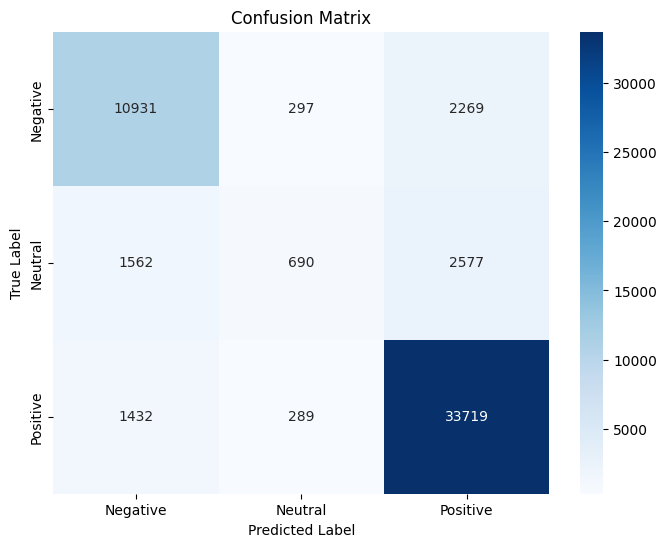

              precision    recall  f1-score   support

           0       0.78      0.81      0.80     13497
           1       0.54      0.14      0.23      4829
           2       0.87      0.95      0.91     35440

    accuracy                           0.84     53766
   macro avg       0.73      0.63      0.64     53766
weighted avg       0.82      0.84      0.82     53766



In [8]:
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = y_pred_prob.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_labels)

labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

print(classification_report(y_test, y_pred_labels))

In [9]:
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-average F1 score:", micro_avg_f1)

Micro-average F1 score: 0.8432838596882788


#With batch normalization

In [11]:
X_train_pad = pad_sequences(sequences_train, maxlen=250, padding='post', truncating='post')
X_val_pad = pad_sequences(sequences_val, maxlen=250, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=250, padding='post', truncating='post')

num_words = min(50000, len(tokenizer.word_index) + 1)
embedding_dim = fasttext_model.vector_size
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

sequence_input = Input(shape=(250,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=250, trainable=False)
embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
bn_1 = BatchNormalization()(conv_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(bn_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
bn_2 = BatchNormalization()(conv_2)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(bn_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
bn_3 = BatchNormalization()(conv_3)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(bn_3)
concat = Concatenate()([gmp_1, gmp_2, gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
dense = Dense(128, activation='relu', name='dense')(drop_out_2)
preds = Dense(3, activation='softmax', name='preds')(dense)
model = Model(sequence_input, preds)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10)

history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=200, batch_size=200, callbacks=[early_stopping])

Epoch 1/200
686/686 [==============================] - 7s 8ms/step - loss: 1.0283 - accuracy: 0.6273 - val_loss: 0.7495 - val_accuracy: 0.6753
Epoch 2/200
686/686 [==============================] - 5s 7ms/step - loss: 0.7415 - accuracy: 0.6988 - val_loss: 0.6643 - val_accuracy: 0.7307
Epoch 3/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6930 - accuracy: 0.7246 - val_loss: 0.6277 - val_accuracy: 0.7479
Epoch 4/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6545 - accuracy: 0.7436 - val_loss: 0.5985 - val_accuracy: 0.7658
Epoch 5/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6317 - accuracy: 0.7557 - val_loss: 0.5798 - val_accuracy: 0.7826
Epoch 6/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6153 - accuracy: 0.7618 - val_loss: 0.5705 - val_accuracy: 0.7864
Epoch 7/200
686/686 [==============================] - 5s 7ms/step - loss: 0.6018 - accuracy: 0.7681 - val_loss: 0.5504 - val_accuracy: 0.7898

1681/1681 [==============================] - 3s 2ms/step


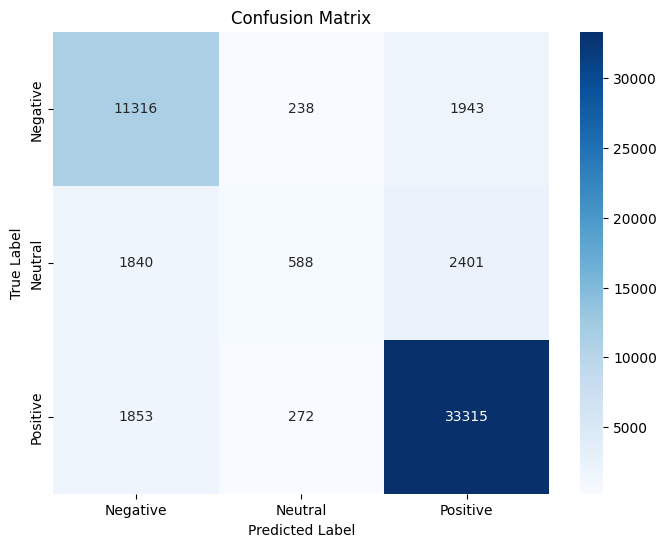

              precision    recall  f1-score   support

           0       0.75      0.84      0.79     13497
           1       0.54      0.12      0.20      4829
           2       0.88      0.94      0.91     35440

    accuracy                           0.84     53766
   macro avg       0.72      0.63      0.63     53766
weighted avg       0.82      0.84      0.82     53766



In [13]:
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = y_pred_prob.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

print(classification_report(y_test, y_pred_labels))

In [14]:
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-average F1 score:", micro_avg_f1)

Micro-average F1 score: 0.8410333668117398
